# Model `FastStep`

In [17]:
# use project files rather than the installed PyBMF

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# # generating synthetic data

# from PyBMF.generators import BlockDiagonalMatrixGenerator

# data = BlockDiagonalMatrixGenerator(m=300, n=500, k=5, overlap=[0.3, 0.2])
# data.generate(seed=1000)
# data.add_noise(noise=[0.4, 0.1], seed=2000)

# data.show_matrix(scaling=0.5)

[I] Found settings.ini at d:\MEGA\PyBMF\examples\settings.ini
[I] Sampling axis 0 to size 300
[I]   sampling seed: 1000
[I]   sampling from: (943, 1682)
[I]   sampling to  : (300, 1682)
[I] Sampling axis 1 to size 500
[I]   sampling seed: 1000
[I]   sampling from: (300, 1682)
[I]   sampling to  : (300, 500)


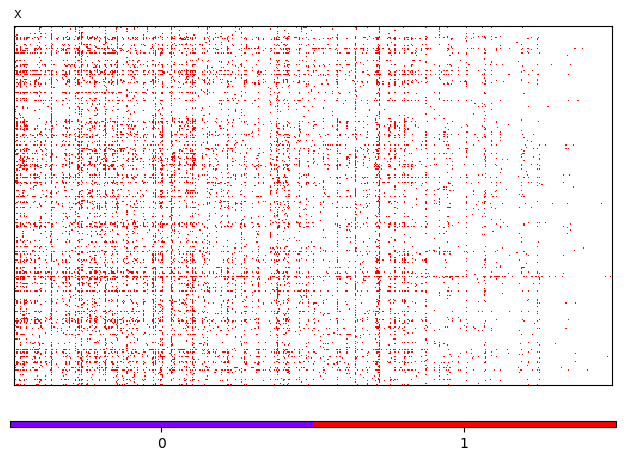

<Figure size 640x480 with 0 Axes>

In [20]:
# loading real-world data

from PyBMF.datasets import MovieLensData

data = MovieLensData(size="100k")
data.load()

idx = data.sample(factor_id=0, n_samples=300, seed=1000)
idx = data.sample(factor_id=1, n_samples=500, seed=1000)

data.show_matrix(scaling=0.5)

In [21]:
# splitting the data into train, validation and test

from PyBMF.datasets import RatioSplit, NoSplit

# split = RatioSplit(X=data.X, val_size=0.1, test_size=0.2, seed=1997)
split = NoSplit(X=data.X)

# split.negative_sample(
#     train_size=split.pos_train_size, 
#     val_size=split.pos_val_size, 
#     test_size=split.pos_test_size, 
#     seed=2023, type='popularity')
split.negative_sample(
    size=split.pos_size, 
    seed=2023, type='popularity')

X_train, X_val, X_test = split.X_train, split.X_val, split.X_test

[I] NoSplit, sampling positives
[I] RatioSplit, sampling positives
[I]   seed         : 1722408175
[I]   train_size   : 10754
[I]   val_size     : 0
[I]   test_size    : 0
[I]   seed         : 1722408175
[I] RatioSplit, sampling negatives
[I]   seed         : 2023
[I]   all_negatives: 139246
[I]   n_negatives  : 10754
[I]   train_size   : 10754
[I]   val_size     : 0
[I]   test_size    : 0
[I]   seed         : 2023


In [22]:
# shared parameters

k = 20
W = 'full'
task = 'reconstruction'

[I] k            : 20
[I] U            : None
[I] V            : None
[I] W            : full
[I] tau          : 20
[I] solver       : line-search
[I] tol          : 0
[I] min_diff     : 0.001
[I] max_round    : 3
[I] max_iter     : 10
[I] init_method  : uniform
[I] normalize_method : matrixwise-normalize
[I] seed         : 1722408180
[I] verbose      : False
[I] display      : False
[I] show_logs    : False
[I] save_model   : False
[I] task         : reconstruction
[I]   show_logs  : False
[I]   save_model : False
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-07-31 14-43-00-475817 FastStep
[I] U, V existed. Skipping initialization.
[I] Normalized from: U: [0.0000, 0.2233], V: [0.0000, 0.2449]
[I] Normalized to  : U: [0.0001, 1.0000], V: [0.0000, 1.0000]


[W] Stopped in advance: Reach maximum round
[I] time elapsed :  2m41s


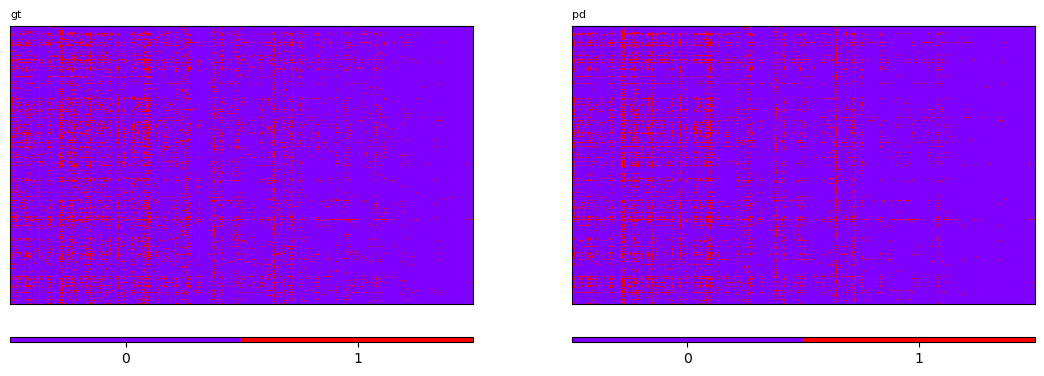

<Figure size 640x480 with 0 Axes>

In [23]:
from PyBMF.models import FastStep

tol = 0
tau = 20
min_diff = 0.001
max_iter = 10
max_round = 3
init_method = 'uniform'

model = FastStep(k=k, U=None, V=None, W=W, tau=tau, solver='line-search', tol=tol, min_diff=min_diff, max_round=max_round, max_iter=max_iter, init_method=init_method, normalize_method='matrixwise-normalize', seed=None)
model.fit(X_train=X_train, task=task, verbose=False, display=False, show_logs=False, save_model=False)

# Result on ordinary multiplication

It's worth noting that the objective function is **NOT** minimizing the error of Boolean product. 
It's the thresholded ordinary product.

X ~ (U @ V) - τ

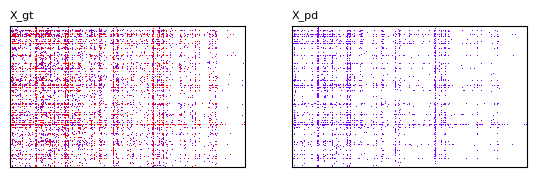

<Figure size 640x480 with 0 Axes>

In [24]:
from PyBMF.utils import get_prediction, binarize, show_matrix, show_factor_distribution, matmul

X_pd = get_prediction(U=model.U, V=model.V, boolean=False)
X_pd = binarize(X_pd, model.tau)
show_matrix([(X_train, [0, 0], 'X_gt'), (X_pd, [0, 1], 'X_pd')], scaling=0.5)

# Result on Boolean multiplication

The original paper did not advise us how to choose the threshold after the real-valued factor matrices are found.

X ~ matmul( (U - u), (V - v) )

In [25]:
U = model.U.copy()
V = model.V.copy()

k = model.k

# initial guess
u, v = 3.2, 3.2

show_factor_distribution(U=U, V=V, us=[u] * k, vs=[v] * k, resolution=100, show_hist=True, show_minmax=True, remove_below=1e-5)

U_bool = binarize(U, u)
V_bool = binarize(V, v)

X_bool = matmul(U_bool, V_bool.T, sparse=True, boolean=True)
# X_bool = U_bool @ V_bool.T
# X_bool = binarize(X_bool, 0.5)
# show_matrix([(X_bool, [0, 0], 'X_bool'), (U_bool, [0, 1], 'U_bool'), (V_bool.T, [1, 0], 'V_bool')], scaling=0.5, colorbar=True)

show_matrix([(X_train, [0, 0], 'X_gt'), (X_bool, [0, 1], 'X_pd')], scaling=0.5, colorbar=True)

0 - [1.226, 4.781], [0.000, 5.375]
1 - [0.000, 3.716], [0.000, 3.738]
2 - [0.000, 4.211], [0.000, 3.248]
3 - [0.000, 3.985], [0.000, 4.002]
4 - [0.000, 4.848], [0.000, 3.381]
5 - [0.000, 4.410], [0.000, 3.741]
6 - [0.000, 2.843], [0.000, 3.804]
7 - [0.000, 4.162], [0.000, 4.077]
8 - [0.000, 3.460], [0.000, 4.269]
9 - [0.000, 10.432], [0.000, 4.145]
10 - [0.000, 3.277], [0.000, 10.006]
11 - [0.000, 5.078], [0.000, 3.996]
12 - [0.000, 3.035], [0.000, 3.715]
13 - [0.000, 5.920], [0.000, 3.076]
14 - [0.000, 4.122], [0.000, 4.005]
15 - [0.000, 2.349], [0.000, 2.436]
16 - [0.000, 3.612], [0.000, 3.434]
17 - [0.000, 4.166], [0.000, 3.223]
18 - [0.000, 6.884], [0.000, 2.950]
19 - [0.000, 2.792], [0.000, 3.179]


<Figure size 640x480 with 0 Axes>

# BinaryMFThreshold

[I] k            : 20
[I] U            : (300, 20)
[I] V            : (500, 20)
[I] W            : full
[I] u            : 0.3
[I] v            : 0.3
[I] lamda        : 5
[I] solver       : line-search
[I] min_diff     : 0.001
[I] max_iter     : 10
[I] init_method  : custom
[I] normalize_method : balance
[I] seed         : 1722411187
[I] verbose      : False
[I] display      : False
[I] show_logs    : False
[I] show_result  : True
[I] save_model   : False
[I] task         : reconstruction
[I]   show_logs  : False
[I]   save_model : False
[I]   show_result: True
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-07-31 15-33-07-615903 BinaryMFThreshold
[I] Normalized from: U: [0.0000, 10.4316], V: [0.0000, 10.0057]
[I] Normalized to  : U: [0.0000, 6.5757], V: [0.0000, 6.5757]


[I] threshold: [3.998, 4.106], F: 3830.3040, U: [0.000, 6.576], V: [0.000, 6.576]:  30%|███       | 3/10 [00:00<00:01,  4.22it/s] 

update a:  0.000244140625 0.00013254540611775897
6.5757, 6.5757
4.1895, 6.5757
0.0000, 0.0000


[I] threshold: [4.232, 3.987], F: 3767.5445, U: [0.000, 6.576], V: [0.000, 6.576]: : 11it [00:02,  3.67it/s]                      


[W] Stopped in advance: Reach maximum iteration
[I] time elapsed :  3s


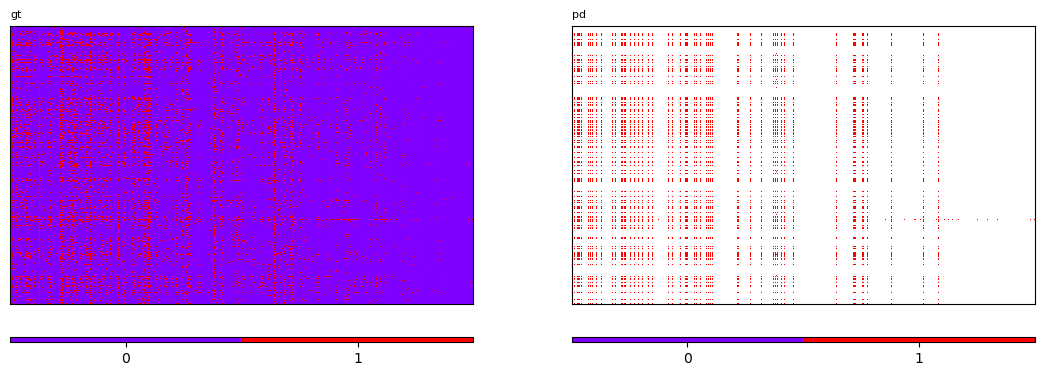

0 - [1.300, 5.069], [0.000, 5.069]
1 - [0.000, 3.727], [0.000, 3.727]
2 - [0.000, 3.698], [0.000, 3.698]
3 - [0.000, 3.993], [0.000, 3.993]
4 - [0.000, 4.048], [0.000, 4.048]
5 - [0.000, 4.062], [0.000, 4.062]
6 - [0.000, 3.289], [0.000, 3.289]
7 - [0.000, 4.119], [0.000, 4.119]
8 - [0.000, 3.844], [0.000, 3.844]
9 - [0.000, 6.576], [0.000, 6.576]
10 - [0.000, 5.726], [0.000, 5.726]
11 - [0.000, 4.505], [0.000, 4.505]
12 - [0.000, 3.358], [0.000, 3.358]
13 - [0.000, 4.268], [0.000, 4.268]
14 - [0.000, 4.063], [0.000, 4.063]
15 - [0.000, 2.392], [0.000, 2.392]
16 - [0.000, 3.522], [0.000, 3.522]
17 - [0.000, 3.665], [0.000, 3.665]
18 - [0.000, 4.507], [0.000, 4.507]
19 - [0.000, 2.980], [0.000, 2.980]


<Figure size 640x480 with 0 Axes>

train  \
                                                                    0   
                 time iter         u         v            F    Recall   
7   31/07/24 03:33:09    7  4.153766  4.002908  3780.294034  0.334201   
8   31/07/24 03:33:09    8  4.177681  4.024019  3771.819920  0.310303   
9   31/07/24 03:33:10    9  4.225384  3.982606  3767.901535  0.319695   
10  31/07/24 03:33:10   10  4.229468  3.987691  3767.550518  0.308629   
11  31/07/24 03:33:10   11  4.231838  3.986521  3767.544456  0.311140   

                                  
                                  
   Precision  Accuracy        F1  
7   0.514090  0.929620  0.405072  
8   0.544017  0.931907  0.395192  
9   0.537271  0.931487  0.400863  
10  0.549231  0.932273  0.395190  
11  0.550601  0.932407  0.397600

[I] k            : 20
[I] U            : (300, 20)
[I] V            : (500, 20)
[I] W            : full
[I] u            : 0.3
[I] v            : 0.3
[I] lamda        : 5
[I] solver       : line-search
[I] min_diff     : 0.001
[I] max_iter     : 10
[I] init_method  : custom
[I] normalize_method : matrixwise-normalize
[I] seed         : 1722411200
[I] verbose      : False
[I] display      : False
[I] show_logs    : False
[I] show_result  : True
[I] save_model   : False
[I] task         : reconstruction
[I]   show_logs  : False
[I]   save_model : False
[I]   show_result: True
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-07-31 15-33-20-281248 BinaryMFThreshold
[I] Normalized from: U: [0.0000, 10.4316], V: [0.0000, 10.0057]
[I] Normalized to  : U: [0.0000, 1.0000], V: [0.0000, 1.0000]


[I] threshold: [0.605, 0.639], F: 4696.8518, U: [0.000, 1.000], V: [0.000, 1.000]: : 11it [00:03,  3.37it/s]                      
d:\MEGA\PyBMF\examples\..\PyBMF\utils\display.py:170: RuntimeWarning: All-NaN slice encountered
  emin, emax = np.nanmin(data) < dmin, np.nanmax(data) > dmax


[W] Stopped in advance: Reach maximum iteration
[I] time elapsed :  3s


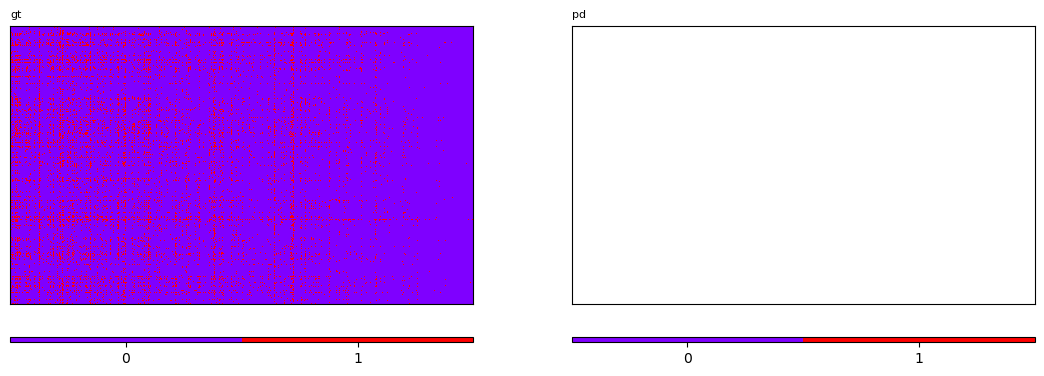

0 - [0.118, 0.458], [0.000, 0.537]
1 - [0.000, 0.356], [0.000, 0.374]
2 - [0.000, 0.404], [0.000, 0.325]
3 - [0.000, 0.382], [0.000, 0.400]
4 - [0.000, 0.465], [0.000, 0.338]
5 - [0.000, 0.423], [0.000, 0.374]
6 - [0.000, 0.272], [0.000, 0.380]
7 - [0.000, 0.399], [0.000, 0.407]
8 - [0.000, 0.332], [0.000, 0.427]
9 - [0.000, 1.000], [0.000, 0.414]
10 - [0.000, 0.314], [0.000, 1.000]
11 - [0.000, 0.487], [0.000, 0.399]
12 - [0.000, 0.291], [0.000, 0.371]
13 - [0.000, 0.568], [0.000, 0.307]
14 - [0.000, 0.395], [0.000, 0.400]
15 - [0.000, 0.225], [0.000, 0.243]
16 - [0.000, 0.346], [0.000, 0.343]
17 - [0.000, 0.399], [0.000, 0.322]
18 - [0.000, 0.660], [0.000, 0.295]
19 - [0.000, 0.268], [0.000, 0.318]


<Figure size 640x480 with 0 Axes>

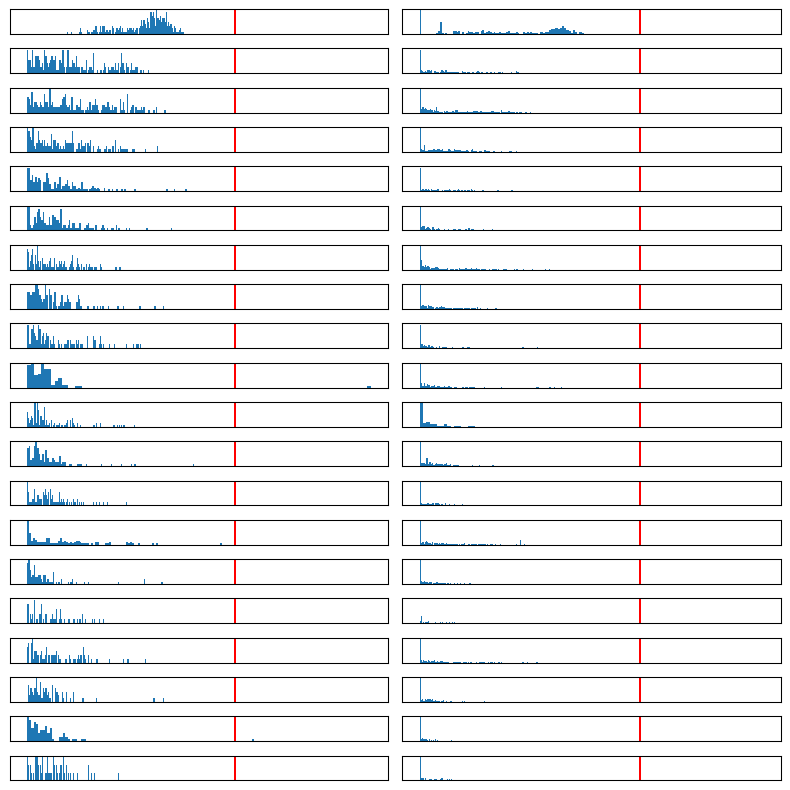

train            \
                                                                 0             
                 time iter         u         v            F Recall Precision   
7   31/07/24 03:33:22    7  0.608842  0.635683  4697.002718    0.0       0.0   
8   31/07/24 03:33:22    8  0.607216  0.635378  4696.958477    0.0       0.0   
9   31/07/24 03:33:23    9  0.606847  0.637654  4696.920098    0.0       0.0   
10  31/07/24 03:33:23   10  0.605257  0.637262  4696.880039    0.0       0.0   
11  31/07/24 03:33:23   11  0.605031  0.639449  4696.851782    0.0       0.0   

                   
                   
    Accuracy   F1  
7   0.928307  0.0  
8   0.928307  0.0  
9   0.928307  0.0  
10  0.928307  0.0  
11  0.928307  0.0

[I] k            : 20
[I] U            : (300, 20)
[I] V            : (500, 20)
[I] W            : full
[I] u            : 0.3
[I] v            : 0.3
[I] lamda        : 5
[I] solver       : line-search
[I] min_diff     : 0.001
[I] max_iter     : 10
[I] init_method  : custom
[I] normalize_method : columnwise-normalize
[I] seed         : 1722411215
[I] verbose      : False
[I] display      : False
[I] show_logs    : False
[I] show_result  : True
[I] save_model   : False
[I] task         : reconstruction
[I]   show_logs  : False
[I]   save_model : False
[I]   show_result: True
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-07-31 15-33-35-732568 BinaryMFThreshold
[I] Normalized from: U: [0.0000, 10.4316], V: [0.0000, 10.0057]
[I] Normalized to  : U: [0.0000, 1.0000], V: [0.0000, 1.0000]


[I] threshold: [0.927, 1.000], F: 4393.2219, U: [0.000, 1.000], V: [0.000, 1.000]:  10%|█         | 1/10 [00:00<00:03,  2.80it/s]

update a:  4.76837158203125e-07 4.397823141883641e-07
1.0000, 1.0000
0.9273, 1.0000
0.0000, 0.0000


[I] threshold: [0.885, 0.880], F: 4167.7901, U: [0.000, 1.000], V: [0.000, 1.000]: : 11it [00:03,  3.43it/s]                      


[W] Stopped in advance: Reach maximum iteration
[I] time elapsed :  3s


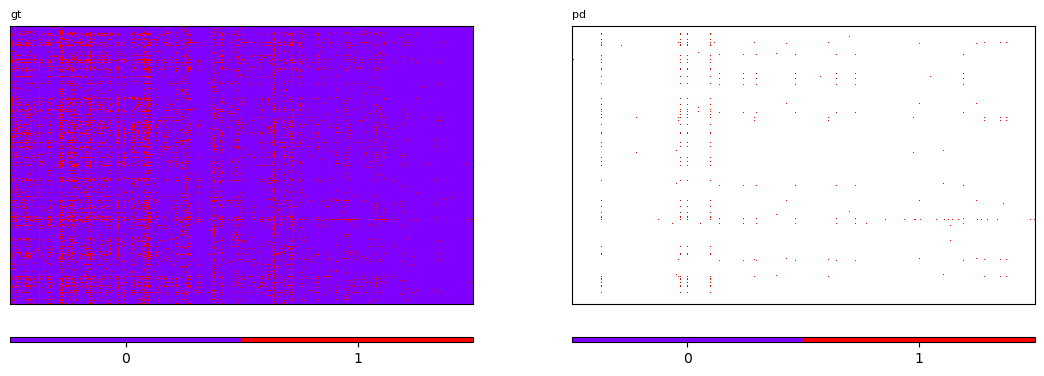

0 - [0.256, 1.000], [0.000, 1.000]
1 - [0.000, 1.000], [0.000, 1.000]
2 - [0.000, 1.000], [0.000, 1.000]
3 - [0.000, 1.000], [0.000, 1.000]
4 - [0.000, 1.000], [0.000, 1.000]
5 - [0.000, 1.000], [0.000, 1.000]
6 - [0.000, 1.000], [0.000, 1.000]
7 - [0.000, 1.000], [0.000, 1.000]
8 - [0.000, 1.000], [0.000, 1.000]
9 - [0.000, 1.000], [0.000, 1.000]
10 - [0.000, 1.000], [0.000, 1.000]
11 - [0.000, 1.000], [0.000, 1.000]
12 - [0.000, 1.000], [0.000, 1.000]
13 - [0.000, 1.000], [0.000, 1.000]
14 - [0.000, 1.000], [0.000, 1.000]
15 - [0.000, 1.000], [0.000, 1.000]
16 - [0.000, 1.000], [0.000, 1.000]
17 - [0.000, 1.000], [0.000, 1.000]
18 - [0.000, 1.000], [0.000, 1.000]
19 - [0.000, 1.000], [0.000, 1.000]


<Figure size 640x480 with 0 Axes>

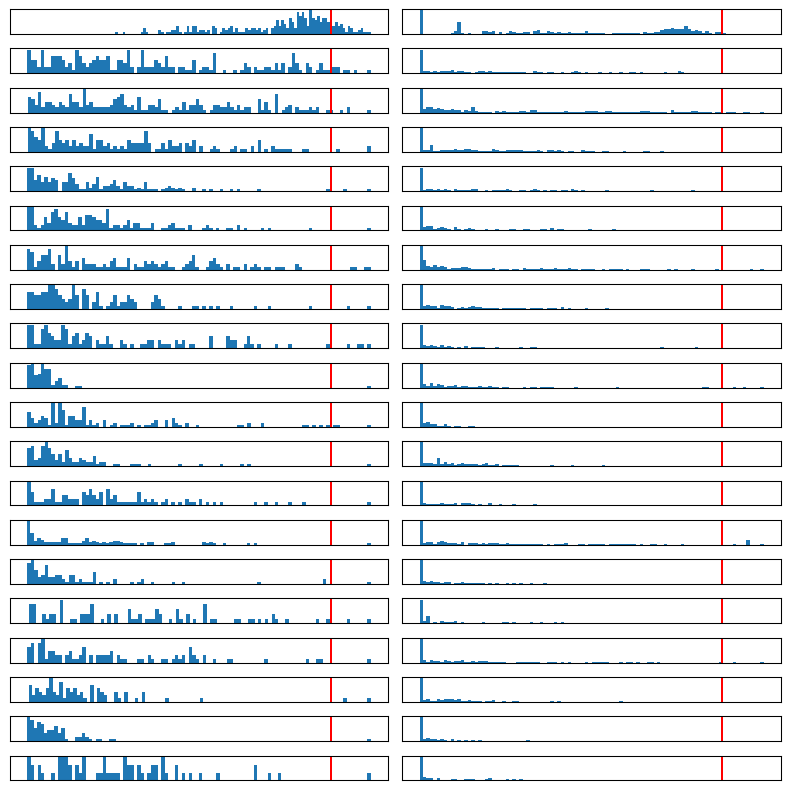

train  \
                                                                    0   
                 time iter         u         v            F    Recall   
7   31/07/24 03:33:37    7  0.873448  0.890370  4169.106678  0.021015   
8   31/07/24 03:33:38    8  0.874544  0.882522  4168.736980  0.034592   
9   31/07/24 03:33:38    9  0.879739  0.884405  4168.312130  0.027804   
10  31/07/24 03:33:38   10  0.880435  0.877882  4168.083995  0.036173   
11  31/07/24 03:33:39   11  0.884789  0.879536  4167.790127  0.029012   

                                  
                                  
   Precision  Accuracy        F1  
7   0.612466  0.928860  0.040637  
8   0.687616  0.929660  0.065870  
9   0.661504  0.929280  0.053364  
10  0.705989  0.929820  0.068819  
11  0.676790  0.929393  0.055640

In [27]:
from PyBMF.models import BinaryMFThreshold

for normalize_method in ['balance', 'matrixwise-normalize', 'columnwise-normalize']: # , 'matrixwise-mapping', 'columnwise-mapping']:

    U, V = model.U.copy(), model.V.copy()

    u, v = 0.3, 0.3

    task = 'reconstruction'
    init_method = 'custom'
    lamda = 5
    solver = 'line-search'

    model_bmft = BinaryMFThreshold(k=k, U=U, V=V, W=W, u=u, v=v, lamda=lamda, init_method=init_method, max_iter=max_iter, solver=solver, normalize_method=normalize_method)
    model_bmft.fit(X_train=X_train, X_val=None, X_test=None, task=task, verbose=False, display=False, show_logs=False, show_result=True, save_model=False)

    show_factor_distribution(U=model_bmft.U, V=model_bmft.V, resolution=100, show_hist=True, show_minmax=True, remove_below=1e-5, us=[model_bmft.u] * model_bmft.k, vs=[model_bmft.v] * model_bmft.k)

    display(model_bmft.logs['updates'].tail())

# BinaryMFThresholdExColumnwise

[I] k            : 20
[I] U            : (300, 20)
[I] V            : (500, 20)
[I] W            : full
[I] us           : 0.3
[I] vs           : 0.3
[I] lamda        : 5
[I] min_diff     : 0.001
[I] max_iter     : 100
[I] init_method  : custom
[I] solver       : line-search
[I] normalize_method : balance
[I] seed         : 1722411231
[I] verbose      : False
[I] display      : False
[I] show_logs    : False
[I] show_result  : True
[I] save_model   : False
[I] task         : reconstruction
[I] verbose      : True
[I]   show_logs  : False
[I]   save_model : False
[I]   show_result: True
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-07-31 15-33-51-239781 BinaryMFThresholdExColumnwise
[I] Normalized from: U: [0.0000, 10.4316], V: [0.0000, 10.0057]
[I] Normalized to  : U: [0.0000, 6.5757], V: [0.0000, 6.5757]
[I] [I] iter: 1
[I]     Wolfe line search iter       : 1
[I]     num of function evals        : 21
[I]     num of gradient evals        : 3
[I]     fu

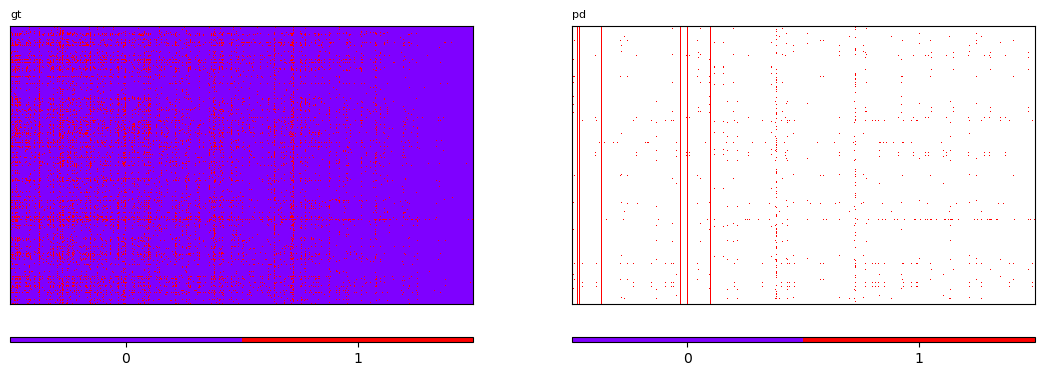

<Figure size 640x480 with 0 Axes>

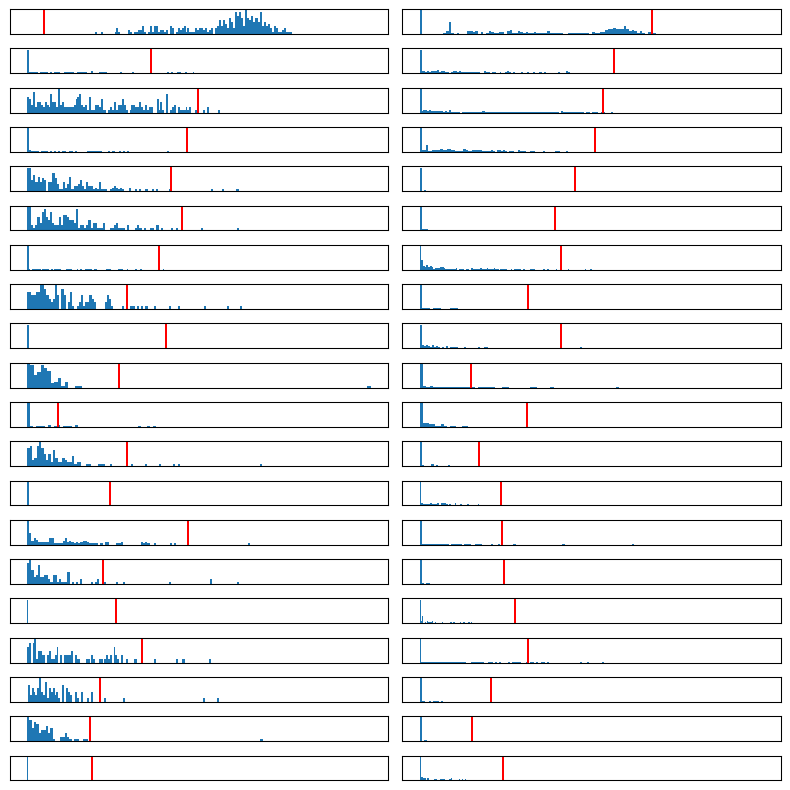

train                      \
                                                 0                       
                  time iter            F    Recall Precision  Accuracy   
97   31/07/24 03:34:26   97  4406.631332  0.138646  0.446541  0.925927   
98   31/07/24 03:34:26   98  4405.672153  0.120234  0.471726  0.927273   
99   31/07/24 03:34:27   99  4405.229771  0.138553  0.447179  0.925960   
100  31/07/24 03:34:27  100  4404.217906  0.120327  0.472263  0.927293   
101  31/07/24 03:34:27  101  4403.887625  0.138925  0.448245  0.926007   

               
               
           F1  
97   0.211594  
98   0.191627  
99   0.211558  
100  0.191789  
101  0.212110

[I] k            : 20
[I] U            : (300, 20)
[I] V            : (500, 20)
[I] W            : full
[I] us           : 0.3
[I] vs           : 0.3
[I] lamda        : 5
[I] min_diff     : 0.001
[I] max_iter     : 100
[I] init_method  : custom
[I] solver       : line-search
[I] normalize_method : matrixwise-normalize
[I] seed         : 1722411276
[I] verbose      : False
[I] display      : False
[I] show_logs    : False
[I] show_result  : True
[I] save_model   : False
[I] task         : reconstruction
[I] verbose      : True
[I]   show_logs  : False
[I]   save_model : False
[I]   show_result: True
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-07-31 15-34-36-791236 BinaryMFThresholdExColumnwise
[I] Normalized from: U: [0.0000, 10.4316], V: [0.0000, 10.0057]
[I] Normalized to  : U: [0.0000, 1.0000], V: [0.0000, 1.0000]
[I] [I] iter: 1
update a:  1.52587890625e-05 1.8398484625666885e-06
update a:  1.8398484625666885e-06 1.4420893559916847e-06
update a:  1

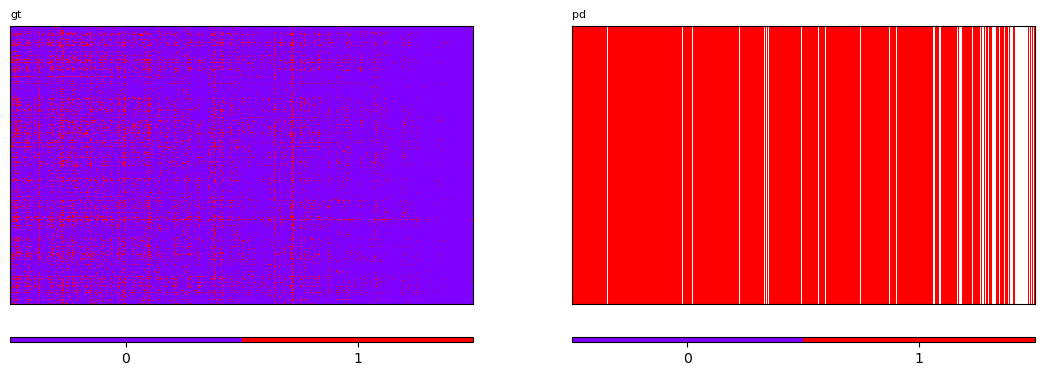

<Figure size 640x480 with 0 Axes>

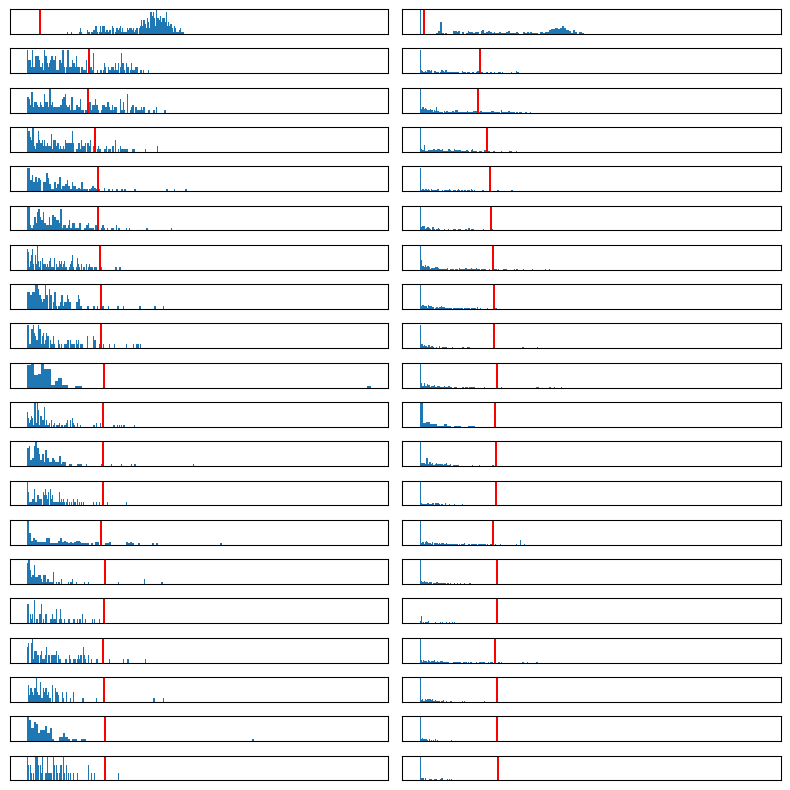

train                      \
                                                 0                       
                time iter              F    Recall Precision  Accuracy   
0  31/07/24 03:34:36    0   88991.329533  0.865445  0.177723  0.703280   
1  31/07/24 03:34:37    1  371712.329152  1.000000  0.081470  0.191693   
2  31/07/24 03:34:37    2  371712.329152  1.000000  0.081470  0.191693   

             
             
         F1  
0  0.294889  
1  0.150665  
2  0.150665

[I] k            : 20
[I] U            : (300, 20)
[I] V            : (500, 20)
[I] W            : full
[I] us           : 0.3
[I] vs           : 0.3
[I] lamda        : 5
[I] min_diff     : 0.001
[I] max_iter     : 100
[I] init_method  : custom
[I] solver       : line-search
[I] normalize_method : columnwise-normalize
[I] seed         : 1722411287
[I] verbose      : False
[I] display      : False
[I] show_logs    : False
[I] show_result  : True
[I] save_model   : False
[I] task         : reconstruction
[I] verbose      : True
[I]   show_logs  : False
[I]   save_model : False
[I]   show_result: True
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-07-31 15-34-47-816111 BinaryMFThresholdExColumnwise
[I] Normalized from: U: [0.0000, 10.4316], V: [0.0000, 10.0057]
[I] Normalized to  : U: [0.0000, 1.0000], V: [0.0000, 1.0000]
[I] [I] iter: 1
update a:  7.62939453125e-06 7.116008862688525e-06
update a:  7.116008862688525e-06 6.552517151122598e-06
update a:  6.55

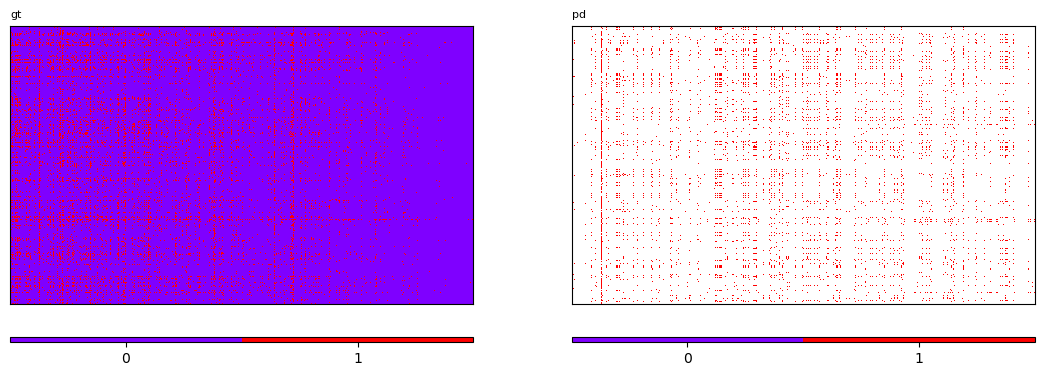

<Figure size 640x480 with 0 Axes>

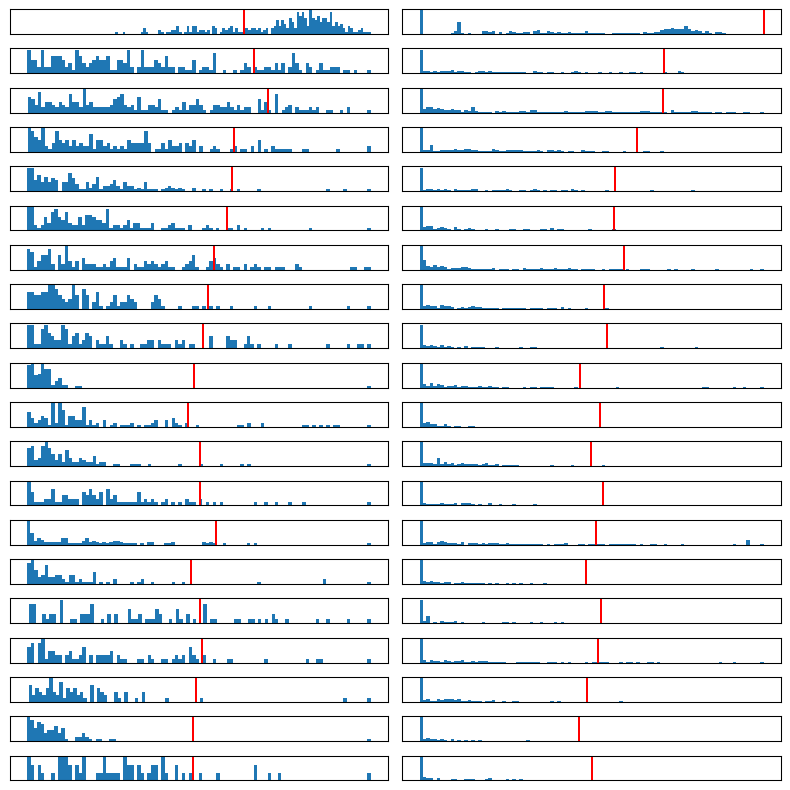

train                      \
                                                 0                       
                time iter              F    Recall Precision  Accuracy   
0  31/07/24 03:34:47    0  318824.925617  1.000000  0.093145  0.301993   
1  31/07/24 03:34:48    1   10824.981268  0.090664  0.180022  0.905200   
2  31/07/24 03:34:48    2   10824.981268  0.090664  0.180022  0.905200   

             
             
         F1  
0  0.170416  
1  0.120594  
2  0.120594

[I] k            : 20
[I] U            : (300, 20)
[I] V            : (500, 20)
[I] W            : full
[I] us           : 0.3
[I] vs           : 0.3
[I] lamda        : 5
[I] min_diff     : 0.001
[I] max_iter     : 100
[I] init_method  : custom
[I] solver       : line-search
[I] normalize_method : matrixwise-mapping
[I] seed         : 1722411298
[I] verbose      : False
[I] display      : False
[I] show_logs    : False
[I] show_result  : True
[I] save_model   : False
[I] task         : reconstruction
[I] verbose      : True
[I]   show_logs  : False
[I]   save_model : False
[I]   show_result: True
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-07-31 15-34-58-638569 BinaryMFThresholdExColumnwise
[I] Normalized from: U: [0.0000, 10.4316], V: [0.0000, 10.0057]
[I] Normalized to  : U: [0.0000, 0.9996], V: [0.0000, 0.9998]
[I] [I] iter: 1
update a:  7.62939453125e-06 6.048003430732885e-06
update a:  6.048003430732885e-06 2.3475857643402262e-06
[I]     Wolfe li

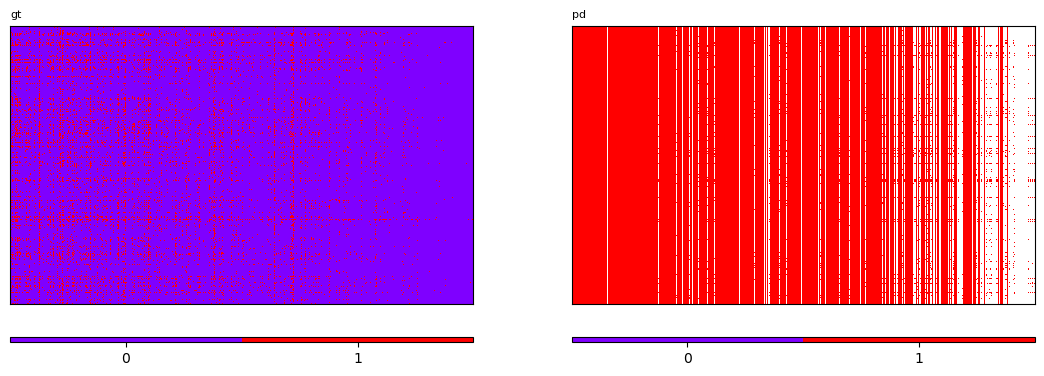

<Figure size 640x480 with 0 Axes>

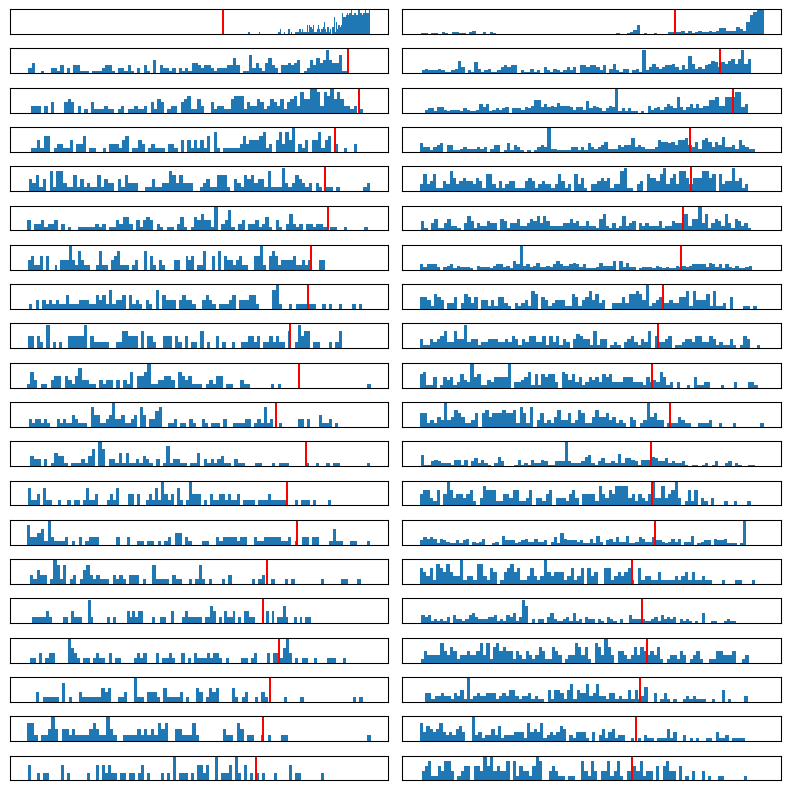

train                      \
                                                0                       
                time iter             F    Recall Precision  Accuracy   
0  31/07/24 03:34:58    0  1.266462e+06  1.000000  0.081470  0.191693   
1  31/07/24 03:34:59    1  5.106209e+04  0.998698  0.093107  0.302500   
2  31/07/24 03:34:59    2  5.106209e+04  0.998698  0.093107  0.302500   

             
             
         F1  
0  0.150665  
1  0.170334  
2  0.170334

[I] k            : 20
[I] U            : (300, 20)
[I] V            : (500, 20)
[I] W            : full
[I] us           : 0.3
[I] vs           : 0.3
[I] lamda        : 5
[I] min_diff     : 0.001
[I] max_iter     : 100
[I] init_method  : custom
[I] solver       : line-search
[I] normalize_method : columnwise-mapping
[I] seed         : 1722411309
[I] verbose      : False
[I] display      : False
[I] show_logs    : False
[I] show_result  : True
[I] save_model   : False
[I] task         : reconstruction
[I] verbose      : True
[I]   show_logs  : False
[I]   save_model : False
[I]   show_result: True
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-07-31 15-35-09-685390 BinaryMFThresholdExColumnwise
[I] Normalized from: U: [0.0000, 10.4316], V: [0.0000, 10.0057]
[I] Normalized to  : U: [0.0000, 0.9967], V: [0.0000, 0.9980]
[I] [I] iter: 1
update a:  3.814697265625e-06 2.334012038419337e-06
update a:  2.334012038419337e-06 2.312413073230528e-06
[I]     Wolfe li

<Figure size 640x480 with 0 Axes>

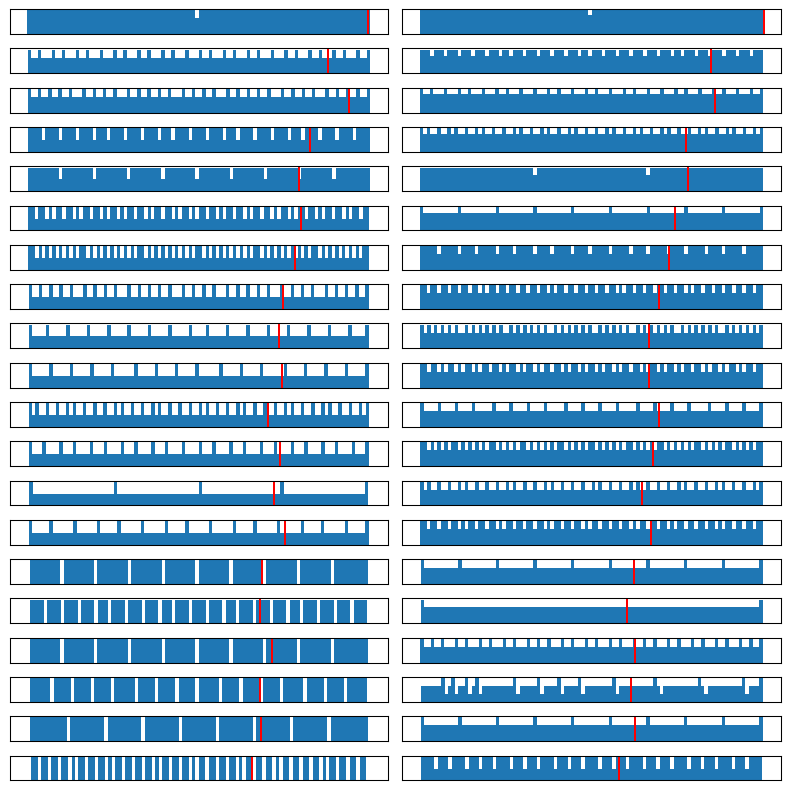

train                      \
                                                0                       
                time iter             F    Recall Precision  Accuracy   
0  31/07/24 03:35:09    0  1.104346e+06  1.000000  0.080492  0.181007   
1  31/07/24 03:35:10    1  2.483396e+04  0.435373  0.123198  0.737373   
2  31/07/24 03:35:10    2  2.483396e+04  0.435373  0.123198  0.737373   

             
             
         F1  
0  0.148992  
1  0.192051  
2  0.192051

In [28]:
from PyBMF.models.BinaryMFThresholdExColumnwise import BinaryMFThresholdExColumnwise

for normalize_method in ['balance', 'matrixwise-normalize', 'columnwise-normalize', 'matrixwise-mapping', 'columnwise-mapping']:

    U, V = model.U.copy(), model.V.copy()

    us, vs = 0.3, 0.3

    task = 'reconstruction'
    init_method = 'custom'
    lamda = 5
    solver = 'line-search'

    model_bmftc = BinaryMFThresholdExColumnwise(k=k, U=U, V=V, W=W, us=us, vs=vs, lamda=lamda, init_method=init_method, max_iter=100, solver=solver, normalize_method=normalize_method)
    model_bmftc.fit(X_train=X_train, X_val=None, X_test=None, task=task, verbose=True, display=False, show_logs=False, show_result=True, save_model=False)

    show_factor_distribution(U=model_bmftc.U, V=model_bmftc.V, resolution=100, show_hist=True, show_minmax=False, remove_below=1e-5, us=model_bmftc.us, vs=model_bmftc.vs)

    display(model_bmftc.logs['updates'].tail())